✅ Loaded best_signcnn.pth
✔️  FP32 ONNX: signcnn.onnx (0.39 MB)


🔨 Running static QDQ quantization…
✔️  QDQ ONNX: signcnn_qdq.onnx (0.11 MB)
✅ Loaded FP32 & QDQ models into ONNX Runtime
Accuracy (64 samples) — FP32: 100.00%, QDQ: 100.00%
Avg inference — FP32: 0.15 ms, QDQ: 0.23 ms


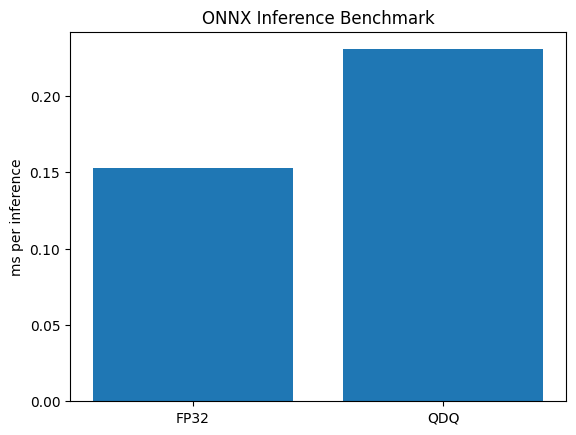

In [ ]:
#!/usr/bin/env python3
"""
02_edge_export_qdq_static.py

This script:
 1. Loads your best PyTorch SignCNN
 2. Exports it to ONNX (FP32)
 3. Runs static quantization with QDQ format
 4. Loads both FP32 and QDQ models locally
 5. Checks accuracy on 64 test samples
 6. Benchmarks inference time and plots results
"""

import os, time
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import onnxruntime as ort

from onnxruntime.quantization import (
    quantize_static,
    CalibrationDataReader,
    QuantFormat,
    QuantType,
)

# 1) Import your model definition
from SignCNN import SignCNN  


# 2) CalibrationDataReader for static quantization
class MNISTDataReader(CalibrationDataReader):
    def __init__(self, input_name, calibration_data):
        self.input_name = input_name
        self.data = calibration_data
        self.idx = 0

    def get_next(self):
        if self.idx >= len(self.data):
            return None
        sample = {self.input_name: self.data[self.idx : self.idx + 1]}
        self.idx += 1
        return sample


def benchmark(session, input_name, sample, runs=100):
    # Warm-up
    for _ in range(10):
        session.run(None, {input_name: sample[:1]})
    # Timed loop
    start = time.perf_counter()
    for _ in range(runs):
        session.run(None, {input_name: sample[:1]})
    return (time.perf_counter() - start) / runs * 1000  # ms


def main():
    device = torch.device('cpu')

    # ——— 1. Load PyTorch model ———
    model = SignCNN().to(device)
    model.load_state_dict(torch.load('best_signcnn.pth', map_location=device))
    model.eval()
    print("Loaded best_signcnn.pth")

    # ——— 2. Export to ONNX (FP32) if missing ———
    onnx_fp = "signcnn.onnx"
    if not os.path.exists(onnx_fp):
        dummy = torch.randn(1, 1, 28, 28, device=device)
        torch.onnx.export(
            model,
            dummy,
            onnx_fp,
            input_names=['input'],
            output_names=['output'],
            dynamic_axes={'input': {0:'batch'}, 'output': {0:'batch'}},
            opset_version=11
        )
    print(f"✔️  FP32 ONNX: {onnx_fp} ({os.path.getsize(onnx_fp)/1e6:.2f} MB)")

    # ——— 3. Prepare calibration data ———
    df = pd.read_csv('sign_mnist_test.csv')
    X = df.drop('label', axis=1).values.astype('float32') / 255.0
    X = X.reshape(-1, 1, 28, 28)
    calib_data = X[:100]  # first 100 samples

    # ——— 4. Static quantize to QDQ ———
    sess_tmp = ort.InferenceSession(onnx_fp)
    inp_name = sess_tmp.get_inputs()[0].name

    onnx_qdq = "signcnn_qdq.onnx"
    print("🔨 Running static QDQ quantization…")
    reader = MNISTDataReader(inp_name, calib_data)
    quantize_static(
        model_input=onnx_fp,
        model_output=onnx_qdq,
        calibration_data_reader=reader,
        quant_format=QuantFormat.QDQ,
        weight_type=QuantType.QInt8,
        activation_type=QuantType.QInt8
    )
    print(f" QDQ ONNX: {onnx_qdq} ({os.path.getsize(onnx_qdq)/1e6:.2f} MB)")

    # ——— 5. Load ONNX Runtime sessions ———
    sess_fp  = ort.InferenceSession(onnx_fp)
    sess_qdq = ort.InferenceSession(onnx_qdq)
    print("Loaded FP32 & QDQ models into ONNX Runtime")

    # ——— 6. Sanity-check accuracy ———
    batch = X[:64]
    labels = df['label'].values[:64]

    out_fp  = sess_fp.run(None, {inp_name: batch})[0]
    out_qdq = sess_qdq.run(None, {inp_name: batch})[0]

    acc_fp  = (np.argmax(out_fp,  axis=1) == labels).mean()
    acc_qdq = (np.argmax(out_qdq, axis=1) == labels).mean()
    print(f"Accuracy (64 samples) — FP32: {acc_fp*100:.2f}%, QDQ: {acc_qdq*100:.2f}%")

    # ——— 7. Benchmark inference time ———
    t_fp  = benchmark(sess_fp,  inp_name, batch, runs=200)
    t_qdq = benchmark(sess_qdq, inp_name, batch, runs=200)
    print(f"Avg inference — FP32: {t_fp:.2f} ms, QDQ: {t_qdq:.2f} ms")

    # ——— 8. Plot comparison ———
    plt.figure()
    plt.bar(['FP32','QDQ'], [t_fp, t_qdq])
    plt.ylabel('ms per inference')
    plt.title('ONNX Inference Benchmark')
    plt.show()


if __name__ == '__main__':
    main()
